# TUIA / AAII - TP1: Redes Densas y Convoluciones - Problema 1

> *Modelo de Regresión para predecir el Índice de Rendimiento Académico.*


# Procedimientos Previos

## Preparación del entorno

### Librerías

In [1]:
# Importar desde Google Drive
!pip install -q gdown

In [2]:
# Datasets
import gdown
import zipfile

# Data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Visualizaciones
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import seaborn as sns

# ML metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, auc

# Redes Neuronales
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Input, Dropout

### GPU

In [3]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

## Dataset

El dataset proporcionado incluye las siguientes variables para cada estudiante:

* **Hours Studied**: El número total de horas dedicadas al estudio por cada estudiante.
* **Previous Scores**: Las puntuaciones obtenidas por los estudiantes en exámenes previos.
* **Extracurricular Activities**: Si el estudiante participa en actividades extracurriculares (Sí o No).
* **Sleep Hours**: El número promedio de horas de sueño que el estudiante tuvo por día.
* **Sample Question Papers Practiced**: El número de cuestionarios de muestra que el estudiante practicó.

Además, el dataset incluye la variable objetivo:
* **Performance Index**: Un índice que representa el rendimiento académico general de cada estudiante, redondeado al entero más cercano. Este índice varía de 10 a 100, donde valores más altos indican un mejor rendimiento.

### Descarga

In [4]:
# TP1-1-student_performance.zip
gdown.download('https://drive.google.com/uc?id=1mfpXVLqDJah-sO0CF29LjKUz5NtKjZqc')

Downloading...
From: https://drive.google.com/uc?id=1mfpXVLqDJah-sO0CF29LjKUz5NtKjZqc
To: /content/TP1-1-student_performance.zip
100%|██████████| 49.7k/49.7k [00:00<00:00, 51.4MB/s]


'TP1-1-student_performance.zip'

### Descompresión

In [5]:
with zipfile.ZipFile('TP1-1-student_performance.zip', 'r') as zip_ref:
    zip_ref.extractall('./TP1-1')

### Carga

In [6]:
# Cargamos el dataset
df = pd.read_csv("TP1-1/Student_Performance.csv")
df

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0
...,...,...,...,...,...,...
9995,1,49,Yes,4,2,23.0
9996,7,64,Yes,8,5,58.0
9997,6,83,Yes,8,5,74.0
9998,9,97,Yes,7,0,95.0


## Análisis Exploratorio

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


In [8]:
df.describe()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800
std,2.589309,17.343152,1.695863,2.867348,19.212558
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


In [9]:
cols = df.columns

for col in cols:
    print("--------------------")
    print("Columna: ", col)
    print("Cantidad de valores nulos: ", df[col].isnull().sum())
    print("Cantidad de valores únicos: ", df[col].nunique())
    print("Tipo de dato: ", df[col].dtype)
    # Si no es numérica, continuar con la siguiente columna
    if df[col].dtype == "object":
        print("--------------------\n")
        continue
    # Si es una columna categórica, mostrar la cantidad de veces que aparece cada valor
    if df[col].nunique() < 10:
        print("Valores únicos: ", df[col].unique())
        print("Cantidad de veces que aparece cada valor: ", df[col].value_counts())
    else:
        # Si es una columna numérica, mostramos media, desvío estándar, mínimo, máximo...
        print("Media: ", df[col].mean())
        print("Desvío estándar: ", df[col].std())
        print("Mínimo: ", df[col].min())
        print("Máximo: ", df[col].max())
    print("--------------------\n")

--------------------
Columna:  Hours Studied
Cantidad de valores nulos:  0
Cantidad de valores únicos:  9
Tipo de dato:  int64
Valores únicos:  [7 4 8 5 3 6 2 1 9]
Cantidad de veces que aparece cada valor:  Hours Studied
1    1152
6    1133
7    1129
3    1119
9    1115
5    1094
8    1088
4    1085
2    1085
Name: count, dtype: int64
--------------------

--------------------
Columna:  Previous Scores
Cantidad de valores nulos:  0
Cantidad de valores únicos:  60
Tipo de dato:  int64
Media:  69.4457
Desvío estándar:  17.343152251047105
Mínimo:  40
Máximo:  99
--------------------

--------------------
Columna:  Extracurricular Activities
Cantidad de valores nulos:  0
Cantidad de valores únicos:  2
Tipo de dato:  object
--------------------

--------------------
Columna:  Sleep Hours
Cantidad de valores nulos:  0
Cantidad de valores únicos:  6
Tipo de dato:  int64
Valores únicos:  [9 4 7 5 8 6]
Cantidad de veces que aparece cada valor:  Sleep Hours
8    1804
7    1676
6    1673
9    162

## Conjuntos de Train y Test

In [10]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=123)

In [11]:
df_train.shape, df_test.shape

((8000, 6), (2000, 6))

## Procesamiento en Train

En esta sección se define una serie de funciones que ejecutan acciones para prcesar los datos en función de las demandas de las consignas y el gusto personal de los desarrolladores del TP.

La estrategia de emplear funciones permite visibilizar más claramente las acciones aplicadas y facilitar la implementación tanto en el conjunto de entrenamiento como prueba.

### Renombrar Columnas

In [12]:
def renombrar_columnas(df):
    """
    Renombra las columnas de un DataFrame con nombres abreviados.

    Parámetros:
    - df: DataFrame: El DataFrame que contiene los datos.

    Retorna:
    - df: DataFrame: El DataFrame con las columnas renombradas.
    """
    # Diccionario con los nombres y sus reemplazos
    nuevos_nombres = {
    'Hours Studied': 'Hs_Studied',
    'Previous Scores': 'Prev_Score',
    'Extracurricular Activities': 'Extra_Act',
    'Sleep Hours': 'Sleep_Hs',
    'Sample Question Papers Practiced': 'Practiced',
    'Performance Index': 'Index'
    }
    df.rename(columns=nuevos_nombres, inplace=True)
    return df

In [13]:
df_train = renombrar_columnas(df_train)

### Filas duplicadas

In [14]:
duplicadas = df_train.duplicated().any()
print("Hay filas duplicadas.") if duplicadas.any() else print("No hay filas duplicadas.")

Hay filas duplicadas.


In [15]:
num_duplicados = df_train.duplicated().sum()
num_duplicados

86

In [16]:
filas_duplicadas = df_train[df_train.duplicated()]
filas_duplicadas

,Hs_Studied,Prev_Score,Extra_Act,Sleep_Hs,Practiced,Index
9460,8,65,No,4,8,57.0
2466,1,99,No,7,3,74.0
7412,5,65,No,4,9,50.0
5219,6,66,Yes,7,7,58.0
7179,1,72,Yes,4,1,44.0
...,...,...,...,...,...,...
1684,9,49,No,8,7,47.0
7427,8,47,No,7,1,36.0
7913,7,87,Yes,4,7,78.0
2338,5,41,No,8,4,26.0


In [17]:
def eliminar_registros_duplicados(df):
    """
    Elimina los registros duplicados de un DataFrame.

    Parámetros:
    - df: DataFrame: El DataFrame que se va a limpiar de registros duplicados.

    Retorna:
    - df_clean: DataFrame: El DataFrame sin registros duplicados.
    """
    df_clean = df.drop_duplicates()
    return df_clean

In [18]:
df_train = eliminar_registros_duplicados(df_train)

In [19]:
df_train.shape

(7914, 6)

### Recategorización de Variables

In [20]:
def recategorizar_variables(df):
    """
    Recategoriza las variable deseadas en un DataFrame.

    Parámetros:
    - df: DataFrame: El DataFrame que contiene los datos.

    Retorna:
    - df_recategorizado: DataFrame: El DataFrame con las variables recategorizadas.
    """
    df_recategorizado = df.copy()

    # Convierte "Yes" en 1 y "No" en 0.
    df_recategorizado['Extra_Act'] = df_recategorizado['Extra_Act'].map({'Yes': 1, 'No': 0})

    return df_recategorizado

In [21]:
df_train = recategorizar_variables(df_train)

### Normalización Min/Max

In [22]:
def escalar_datos(df, scaler_dict=None):
    """
    Escala las características en un DataFrame utilizando MinMaxScaler.

    Parámetros:
    - df: DataFrame: El DataFrame que contiene los datos.
    - scaler_dict: dict: Un diccionario que contiene los objetos scaler utilizados para escalar cada columna (opcional).

    Retorna:
    - df_scaled: DataFrame: El DataFrame con las características escaladas.
    - scaler_dict: dict: Un diccionario que contiene los objetos scaler utilizados para escalar cada columna.
    """
    # Si no se proporciona un diccionario de scalers, inicializar uno
    if scaler_dict is None:
        scaler_dict = {}

    # Iterar sobre cada columna en el DataFrame
    for columna in df.columns:
        # Inicializar un scaler para cada columna si no está en el diccionario
        if columna not in scaler_dict:
            scaler_dict[columna] = MinMaxScaler()
        # Escalar la columna y reemplazar los valores en el DataFrame
        df[columna] = scaler_dict[columna].fit_transform(df[[columna]])

    # Devolver el DataFrame escalado y el diccionario de scalers
    return df, scaler_dict

In [23]:
df_train, train_scaler_dict = escalar_datos(df_train)

In [24]:
df_train

,Hs_Studied,Prev_Score,Extra_Act,Sleep_Hs,Practiced,Index
9216,0.625,0.677966,0.0,0.8,0.444444,0.674157
7324,0.875,0.762712,1.0,0.6,0.666667,0.764045
918,0.750,0.254237,0.0,0.0,0.444444,0.359551
5902,0.375,0.847458,1.0,0.8,0.555556,0.674157
2807,0.125,0.745763,0.0,0.0,0.111111,0.505618
...,...,...,...,...,...,...
9785,0.250,0.254237,0.0,0.2,0.777778,0.280899
7763,1.000,0.203390,0.0,0.0,0.000000,0.404494
5218,0.375,0.711864,1.0,0.8,1.000000,0.640449
1346,0.375,0.084746,0.0,0.2,0.444444,0.157303


### Conjuntos X e y

In [25]:
def separar_Xy(df, target_column):
    """
    Separa las variables explicativas y la variable objetivo de un DataFrame.

    Parámetros:
    - df: DataFrame: El DataFrame que contiene los datos.
    - target_column: str: El nombre de la columna que se utilizará como variable objetivo.

    Retorna:
    - X: DataFrame: El DataFrame que contiene las variables explicativas.
    - y: DataFrame: El DataFrame que contiene la variable objetivo.
    """
    # Variables explicativas (todas las columnas excepto la columna objetivo)
    X = df.drop([target_column], axis=1).copy()

    # Variable objetivo (solo la columna objetivo)
    y = df[[target_column]].copy()

    return X, y

In [26]:
X_train, y_train = separar_Xy(df_train, 'Index')

In [27]:
X_train.shape, y_train.shape

((7914, 5), (7914, 1))

## Visualizaciones

### Histogramas

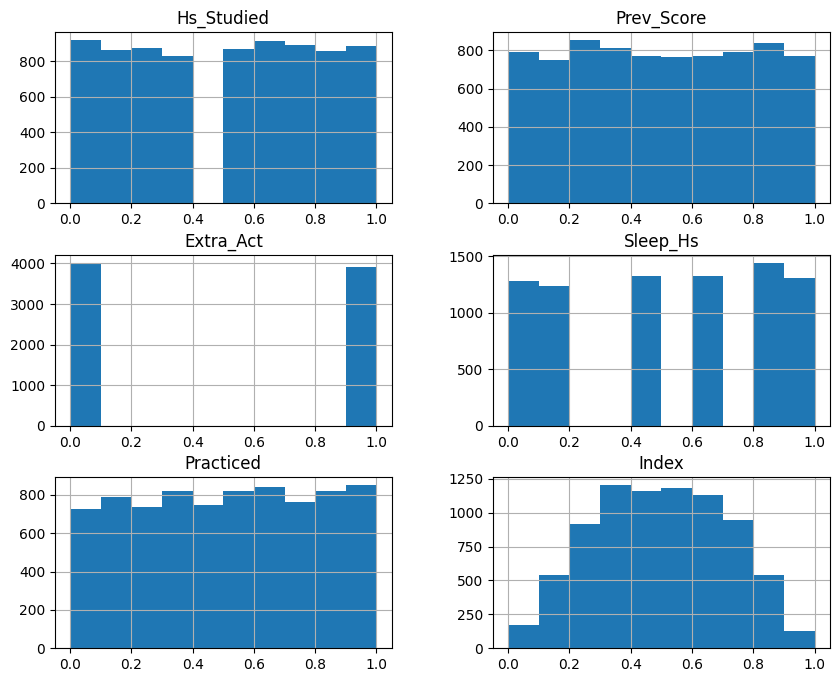

In [28]:
df_train.hist(figsize=(10,8))
plt.show()

### Boxplot Matrix

In [29]:
continuous_features = []
for feat in df_train.columns:
    if df_train[feat].nunique() > 2:
        continuous_features.append(feat)

num_cols = 3
num_rows = (len(continuous_features) + 1) // num_cols
fig = make_subplots(rows=num_rows, cols=num_cols)

for i, feature in enumerate(continuous_features):
    row = i // num_cols + 1
    col = i % num_cols + 1

    fig.add_trace(go.Box(x=df_train[feature], name = ' '), row=row, col=col)

    fig.update_yaxes(title_text = ' ', row=row, col=col)
    fig.update_xaxes(title_text= feature, row=row, col=col)
    fig.update_layout(
        title=f'<b>Boxplot Matrix<br> <sup> Continuous Features</sup></b>',
        showlegend=False, yaxis=dict(tickangle=-90)
    )

fig.update_layout(
    height=200 * num_rows,
    width=800,
    margin=dict(t=50, l=50),
    template= 'simple_white'
)
fig.show()

### Matriz de Correlación

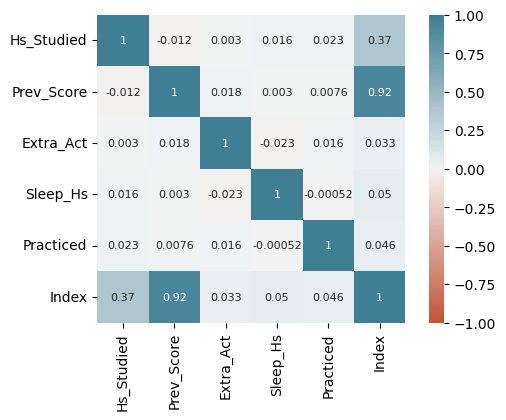

In [30]:
corr = df_train.corr()

plt.figure(figsize=(6, 4))
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square = True,
    annot = True,
    annot_kws = {'size': 8}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='center'
)
plt.show()

***Observación:*** Se aprecia una contundente correlación entre dos variables explicativas ("Hours Studied"	y "Previous Scores") que podrían simplificar el modelo final y predecir con eficacia la variable deseada. El resto de las variables tiene un impacto lineal sobre la variable target que es prácticamente despreciable.

De todos modos, se decide no filtrarlas y trabajar con todo el dataset en su conjunto para intentar que el modelo detecte relaciones más complejas entre el resto de las variables. Decisión que se apoya, también, en la certeza de que la cantidad de características es muy pequeña y que su inclusión o eliminación no producirá variaciones significativas en el rendimiento del modelo.

### Distribuciones

<Figure size 1200x800 with 0 Axes>

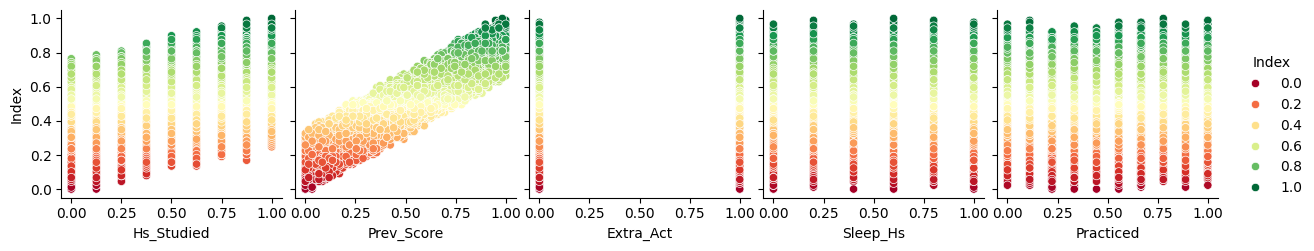

In [31]:
plt.figure(figsize=(12, 8))
sns.pairplot(df_train, hue='Index', x_vars=df_train.drop('Index', axis=1).columns, y_vars='Index', palette='RdYlGn')
plt.show()

# Red Neuronal / Regresión

### Definición de métrica

In [32]:
def r2_ajustado(y_true, y_pred, n, p):
    """
    Calcula el coeficiente de determinación ajustado (R2 ajustado).

    Parámetros:
    - y_true: array-like: Valores reales de la variable objetivo.
    - y_pred: array-like: Valores predichos de la variable objetivo.
    - n: int: Número de observaciones en la muestra.
    - p: int: Número de características utilizadas en el modelo.

    Retorna:
    - r2_adj: float: Coeficiente de determinación ajustado.
    """
    r2 = r2_score(y_true, y_pred)
    r2_aj = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    return r2_aj


## Procesamiento en Test

In [33]:
df_test

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
2656,8,86,Yes,7,3,82.0
445,3,56,No,7,6,36.0
9505,2,46,Yes,7,9,23.0
332,1,40,No,5,9,10.0
4168,5,65,No,9,0,54.0
...,...,...,...,...,...,...
8018,2,88,Yes,6,6,65.0
6463,2,63,No,8,9,39.0
2883,3,62,No,8,1,41.0
7895,9,41,No,9,8,39.0


### Pipeline de procesamiento

Se aplica el mismo procesamiento que a los datos de entrenamiento.

In [34]:
df_test = renombrar_columnas(df_test)
df_test = eliminar_registros_duplicados(df_test)
df_test = recategorizar_variables(df_test)
df_test, _ = escalar_datos(df_test, train_scaler_dict)

In [35]:
df_test

,Hs_Studied,Prev_Score,Extra_Act,Sleep_Hs,Practiced,Index
2656,0.875,0.779661,1.0,0.6,0.333333,0.800000
445,0.250,0.271186,0.0,0.6,0.666667,0.288889
9505,0.125,0.101695,1.0,0.6,1.000000,0.144444
332,0.000,0.000000,0.0,0.2,1.000000,0.000000
4168,0.500,0.423729,0.0,1.0,0.000000,0.488889
...,...,...,...,...,...,...
8018,0.125,0.813559,1.0,0.4,0.666667,0.611111
6463,0.125,0.389831,0.0,0.8,1.000000,0.322222
2883,0.250,0.372881,0.0,0.8,0.111111,0.344444
7895,1.000,0.016949,0.0,1.0,0.888889,0.322222


### Conjuntos X e y

In [36]:
X_test, y_test = separar_Xy(df_test, 'Index')

In [37]:
X_test.shape, y_test.shape

((1996, 5), (1996, 1))

## Modelo

### Definición y entrenamiento

In [38]:
# Definición del Modelo
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(4, activation='relu'), Dropout(0.0),
    Dense(4, activation='relu'), Dropout(0.0),
    Dense(1, activation='linear')
])

Este modelo consiste en una capa de entrada seguida de dos capas ocultas, cada una con 4 neuronas y activadas por la función ReLU, con una capa de dropout entre ellas para regularización, y una capa de salida con una sola neurona y activación lineal.

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 24        
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense_1 (Dense)             (None, 4)                 20        
                                                                 
 dropout_1 (Dropout)         (None, 4)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 49 (196.00 Byte)
Trainable params: 49 (196.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
# Entrenamiento
print("Inicio del Entrenamiento\n-------------------------")
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error', 'mae'])

# Definir el número de características (p) para calcular R2 ajustado
p = X_train.shape[1]

history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, verbose=1)
print("-------------------------\nFin del Entrenamiento")

Inicio del Entrenamiento
-------------------------
Epoch 1/20
99/99 [==============================] - 1s 5ms/step - loss: 0.6263 - mean_squared_error: 0.6263 - mae: 0.7208 - val_loss: 0.3382 - val_mean_squared_error: 0.3382 - val_mae: 0.5178
Epoch 2/20
99/99 [==============================] - 1s 5ms/step - loss: 0.1640 - mean_squared_error: 0.1640 - mae: 0.3319 - val_loss: 0.0734 - val_mean_squared_error: 0.0734 - val_mae: 0.2219
Epoch 3/20
99/99 [==============================] - 1s 5ms/step - loss: 0.0592 - mean_squared_error: 0.0592 - mae: 0.2006 - val_loss: 0.0517 - val_mean_squared_error: 0.0517 - val_mae: 0.1871
Epoch 4/20
99/99 [==============================] - 1s 6ms/step - loss: 0.0426 - mean_squared_error: 0.0426 - mae: 0.1701 - val_loss: 0.0379 - val_mean_squared_error: 0.0379 - val_mae: 0.1602
Epoch 5/20
99/99 [==============================] - 0s 5ms/step - loss: 0.0278 - mean_squared_error: 0.0278 - mae: 0.1351 - val_loss: 0.0210 - val_mean_squared_error: 0.0210 - val_m

### Visualización de Métricas

In [41]:
# Predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

63/63 [==============================] - 0s 1ms/step


Mean Squared Error (MSE): 0.00
Mean Absolute Error (MAE): 0.02
R2 Score: 0.98
R2 Ajustado: 0.98



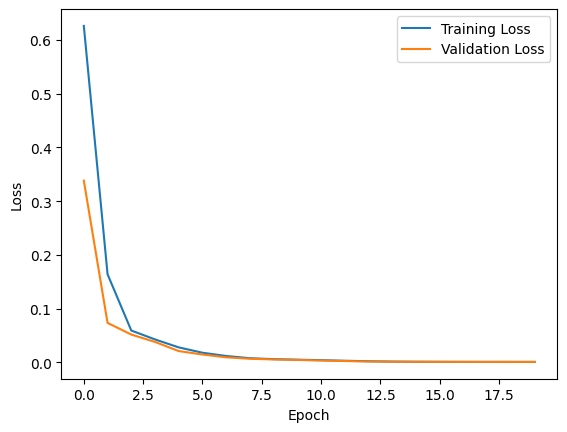

In [42]:
# Calcular R2 ajustado
n = len(y_test)
r2_aj = r2_ajustado(y_test, y_pred, n, p)

# Métricas de regresión
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE): {:.2f}".format(mse))
print("Mean Absolute Error (MAE): {:.2f}".format(mae))
print("R2 Score: {:.2f}".format(r2))
print("R2 Ajustado: {:.2f}\n".format(r2_aj))

# Graficar la curva de aprendizaje
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Predicciones

In [47]:
# Crear DataFrame con datos originales
predicciones = pd.DataFrame(df_test, columns=df_test.columns)

# Obtener los scalers para revertir la normalización
for columna in df_test.columns:
    if columna != 'Index' and columna != 'Predicted Index':
        predicciones[columna] = train_scaler_dict[columna].inverse_transform(predicciones[columna].values.reshape(-1, 1))

# Aplicar la transformación inversa solo a las columnas 'Index' y 'Predicted Index'
predicciones['Index'] = y_test
predicciones['Predicted Index'] = y_pred
predicciones[['Index', 'Predicted Index']] = train_scaler_dict['Index'].inverse_transform(predicciones[['Index', 'Predicted Index']])
predicciones['Predicted Index'] = predicciones['Predicted Index'].round(3)  # Redondear a 3 decimales


# Mostrar la tabla de predicciones
predicciones

,Hs_Studied,Prev_Score,Extra_Act,Sleep_Hs,Practiced,Index,Predicted Index
2656,8.0,86.0,1.0,7.0,3.0,82.0,80.980
445,3.0,56.0,0.0,7.0,6.0,36.0,34.592
9505,2.0,46.0,1.0,7.0,9.0,23.0,24.126
332,1.0,40.0,0.0,5.0,9.0,10.0,21.508
4168,5.0,65.0,0.0,9.0,0.0,54.0,50.138
...,...,...,...,...,...,...,...
8018,2.0,88.0,1.0,6.0,6.0,65.0,64.849
6463,2.0,63.0,0.0,8.0,9.0,39.0,39.912
2883,3.0,62.0,0.0,8.0,1.0,41.0,40.734
7895,9.0,41.0,0.0,9.0,8.0,39.0,28.254


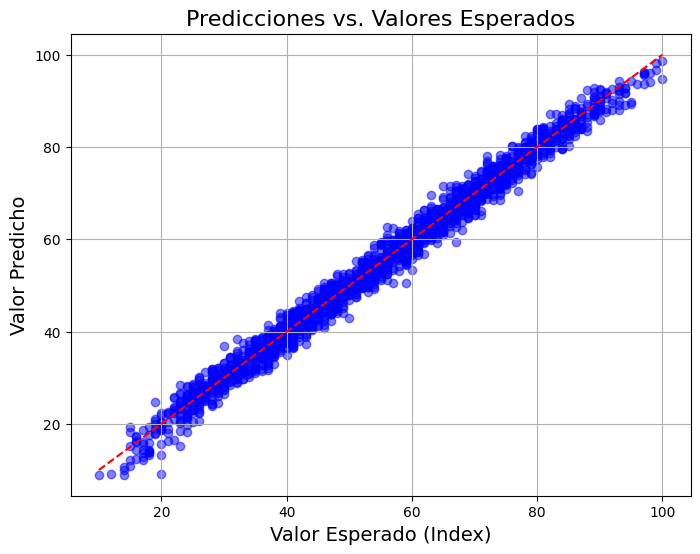

In [ ]:
# Crear el gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(predicciones['Index'], predicciones['Predicted Index'], color='blue', alpha=0.5)  # Scatter plot de los valores esperados vs. predichos
plt.plot([predicciones['Index'].min(), predicciones['Index'].max()], [predicciones['Index'].min(), predicciones['Index'].max()], color='red', linestyle='--')  # Línea diagonal para referencia
plt.title('Predicciones vs. Valores Esperados', fontsize=16)
plt.xlabel('Valor Esperado (Index)', fontsize=14)
plt.ylabel('Valor Predicho', fontsize=14)
plt.grid(True)
plt.show()

# Observaciones finales

Puede concluirse que para la resolución de este problema, el dataset provisto entrega unos datos muy generosos, tanto en el comportamiento de las variables como en la distribución de las mismas.

El modelo de red neuronal densa para este problema de regresión logra unos resultados excelentes sin demasiado esfuerzo ni complejidad en la arquitectura.